# ADL Model Tests

Summary : 
ADL trained using RELU activations obviously clips  the lower bound to zero , producing zero response to negative signal. This can be seen from range of denoised results being [0,1]. Plots also show the same. 
Hence, all 'denoiser' related activations having role in producing the denoised output need to be changed to 'Tanh'. 

In [61]:
# from google.colab import drive
# drive.mount('/content/drive')

# !pip install -qq rich pytorch-lightning==1.7.7 scikit-image==0.19.2
# !git clone https://github.com/jayantb1019/adl_seismic.git
# !mkdir -p /content/adl_seismic/data
# !unzip /content/drive/MyDrive/faciesmark.zip -d /content/adl_seismic/data/.
# !cp /content/drive/MyDrive/denoiser_20230213_epoch=49-step=27600.ckpt /content/denoiser_20230213_epoch=49-step=27600.ckpt
# !cp /content/drive/MyDrive/discriminator_20230213_epoch=49-step=27600.ckpt /content/discriminator_20230213_epoch=49-step=27600.ckpt

In [62]:
import numpy as np 
import pytorch_lightning as pl 
import torch 
import yaml

import matplotlib.pyplot as plt

import sys 
sys.path.append("../models")
sys.path.append("../utils")
sys.path.append("../noise")
sys.path.append("../lightning_logs")
sys.path.append("../data")

# sys.path.append(r"..\models")
# sys.path.append(r"..\utils")
# sys.path.append(r"..\lightning_logs")
# sys.path.append(r"..\data")


from adl import Efficient_U
from random_noise import add_noise

In [63]:


CONFIG_PATH= '../config/config_adl_faciesmark.yaml'
test_data_path = '../data/faciesmark/test_once/test2_seismic.npy'
ckpt_path = '../lightning_logs/denoiser_20230214_tanh_epoch=15-step=8832.ckpt'

# CONFIG_PATH = r'Z:\experiments_feb\config\config_adl_faciesmark.yaml'
# test_data_path = r'Z:\experiments_feb\data\faciesmark\test_once\test2_seismic.npy'
# ckpt_path = r'Z:\experiments_feb\lightning_logs\denoiser_20230213_epoch=49-step=27600.ckpt'

def get_config(config_path) : 
    # read config file 
    with open(config_path, 'r') as f : 
        config = yaml.safe_load(f)
    f.close()
    return config

config = get_config(CONFIG_PATH)


In [64]:
test_data = np.load(test_data_path)
noisy_test_data = add_noise(test_data, mode='gaussian', mean=0,noise_factor=0.01)
model = Efficient_U.load_from_checkpoint(checkpoint_path=ckpt_path, config=config)


Lightning automatically upgraded your loaded checkpoint from v1.7.7 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../lightning_logs/denoiser_20230214_tanh_epoch=15-step=8832.ckpt`


In [65]:
random_iline_no = np.random.randint(600)
random_iline_no

38

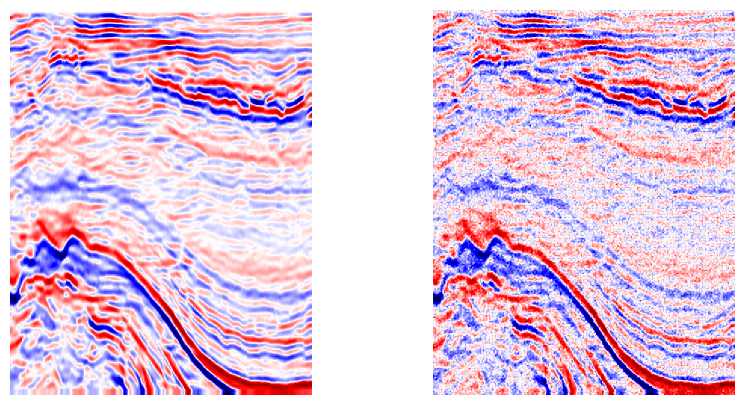

In [66]:
fig, ax = plt.subplots(ncols=2, figsize=(5*2, 5))

clean_inline = test_data[random_iline_no]
noisy_inline = noisy_test_data[random_iline_no]

kwargs = dict(cmap = 'seismic', vmin = -1, vmax = 1)

ax[0].imshow(clean_inline.T, **kwargs)
ax[0].axis('off')
ax[1].imshow(noisy_inline.T, **kwargs)
ax[1].axis('off')
plt.show()

In [67]:
# padded input 
test_pd = np.zeros((noisy_test_data.shape[0],noisy_test_data.shape[1],noisy_test_data.shape[2] + 1 ))
display(test_pd.shape)

test_pd[:,:,:noisy_test_data.shape[2]] = noisy_test_data

test_pd = test_pd.transpose(0,2,1)

(601, 200, 256)

In [68]:
device = 'cuda'
torch.cuda.empty_cache()
import gc 
gc.collect()
noisy_test_tensor = torch.from_numpy(np.expand_dims(test_pd, axis=1)).float().to(device)
model = model.to(device)
model.eval()

with torch.no_grad() : 
    denoised , _ , _ = model(noisy_test_tensor[:10])

In [69]:
denoised.shape

torch.Size([10, 1, 256, 200])

In [70]:
torch.round(torch.min(denoised)) , torch.max(denoised)

(tensor(-1., device='cuda:0'), tensor(0.9938, device='cuda:0'))

In [71]:
denoised = denoised.to('cpu').numpy()

In [72]:
denoised = np.squeeze(denoised)[:,:,:256]

In [73]:
denoised.shape

(10, 256, 200)

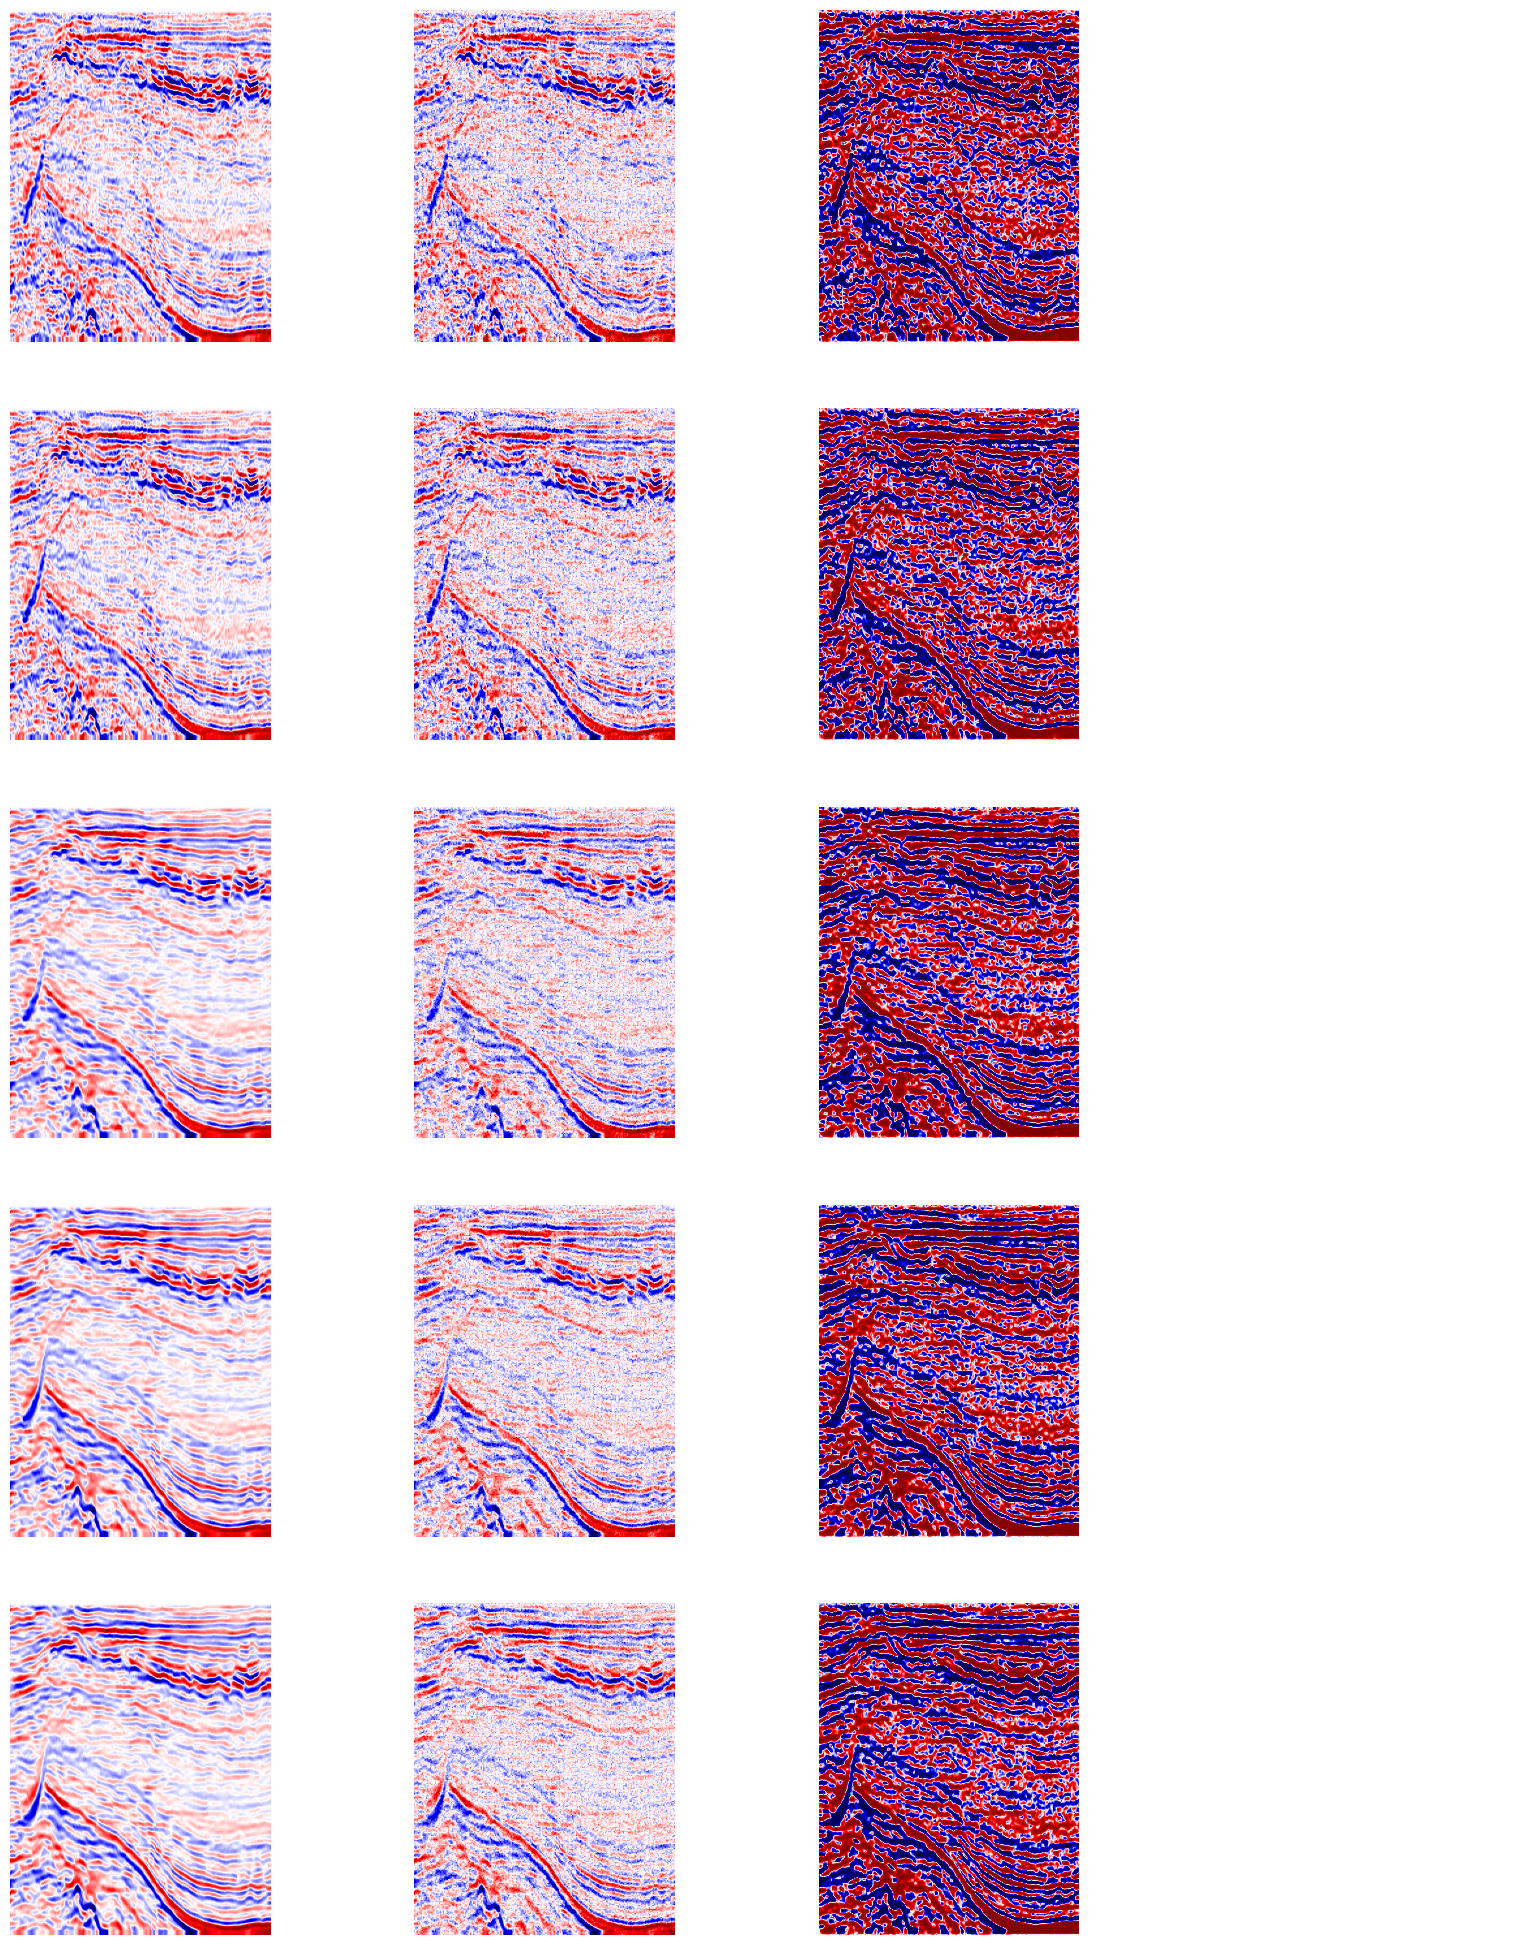

In [75]:
fig, ax = plt.subplots(ncols=4, nrows = 5, figsize=(5*4, 5 * 5))

for i in range(5) : 
    clean_inline = test_data[i]
    noisy_inline = noisy_test_data[i]
    denoised_inline = denoised[i]

    # # diff = clean_inline[:,:256] - denoised[i]
    # diff = clean_inline - denoised_inline[:,:-1]

    kwargs = dict(cmap = 'seismic', vmin = -1, vmax = 1)

    ax[i,0].imshow(clean_inline.T, **kwargs)
    ax[i,0].axis('off')
    ax[i,1].imshow(noisy_inline.T, **kwargs)
    ax[i,1].axis('off')
    ax[i,2].imshow(denoised_inline, **kwargs)
    ax[i,2].axis('off')
    # ax[i,3].imshow(diff.T, **kwargs)
    ax[i,3].axis('off')
plt.show()